In [40]:

%pip install duckduckgo_search
%pip install -Uqq fastai

import requests
import os
from duckduckgo_search import DDGS
import time
from requests.exceptions import SSLError, ConnectionError
from fastai.vision.all import *
from fastai.vision.widgets import *

# Crear una instancia de DDGS
ddgs = DDGS()

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [41]:
nombre_proyecto = 'osos'

In [4]:
import os
import requests
import time
from requests.exceptions import SSLError, ConnectionError

def descargar_imagenes(keywords, max_results=100):
    # Directorio de destino para las imágenes
    destination_folder = f'c:/{nombre_proyecto}/img'
    if not os.path.exists(destination_folder):
        os.makedirs(destination_folder)

    # Iterar sobre las palabras clave
    for keyword in keywords:
        # Crear un directorio separado para cada palabra clave
        keyword_folder = os.path.join(destination_folder, keyword)
        if not os.path.exists(keyword_folder):
            os.makedirs(keyword_folder)

        # Realizar la búsqueda de imágenes para cada palabra clave
        ddgs_images_gen = ddgs.images(keyword, max_results=max_results)
        results = [r for r in ddgs_images_gen]

        # Descargar y guardar cada imagen
        num_downloads = 0
        for i, result in enumerate(results):
            url_image = result['image']
            file_name = os.path.join(keyword_folder, f"image_{i+1}.jpg")

            try:
                # Realizar la solicitud GET para descargar la imagen
                response = requests.get(url_image)
                response.raise_for_status()

                # Guardar la imagen en el archivo local
                with open(file_name, 'wb') as file:
                    file.write(response.content)

                num_downloads += 1
                print(f"Descargada y guardada la imagen como {file_name}")

                # Si se han descargado más de 50 imágenes, pausar durante 5 segundos
                if num_downloads > 50:
                    print("Más de 50 imágenes han sido descargadas. Pausando durante 5 segundos...")
                    time.sleep(5)
                    num_downloads = 0

            except SSLError as ssl_error:
                print(f"SSLError al descargar la imagen {url_image}: {ssl_error}")
            except ConnectionError as conn_error:
                print(f"ConnectionError al descargar la imagen {url_image}: {conn_error}")
            except Exception as e:
                print(f"Error al descargar la imagen {url_image}: {e}")

# Palabras clave para la búsqueda de imágenes
keywords = [
    "North American Black Bear",
    "Brown Bear",
    "Polar Bear",
    "Asiatic Black Bear",
    "Andean Bear or Spectacled Bear",
    "Giant Panda",
    "Sloth Bear",
    "Sun Bear",
    "Teddy"
]
# Llamar a la función para descargar imágenes para las palabras clave dadas
descargar_imagenes(keywords)


Descargada y guardada la imagen como c:/img\North American Black Bear\image_1.jpg
Error al descargar la imagen https://www.pacificforest.org/wp-content/uploads/2018/08/20254986474_c3580a9965_k.jpg: 406 Client Error: Not Acceptable for url: https://www.pacificforest.org/wp-content/uploads/2018/08/20254986474_c3580a9965_k.jpg
ConnectionError al descargar la imagen https://kathleenreeder.com/wp-content/uploads/2016/08/2011-08-19_129_VSBS.jpeg: HTTPSConnectionPool(host='kathleenreeder.com', port=443): Max retries exceeded with url: /wp-content/uploads/2016/08/2011-08-19_129_VSBS.jpeg (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x0000013A19074D10>, 'Connection to kathleenreeder.com timed out. (connect timeout=None)'))
Descargada y guardada la imagen como c:/img\North American Black Bear\image_4.jpg
Descargada y guardada la imagen como c:/img\North American Black Bear\image_5.jpg
Descargada y guardada la imagen como c:/img\North American Black Bear\image_6.jp

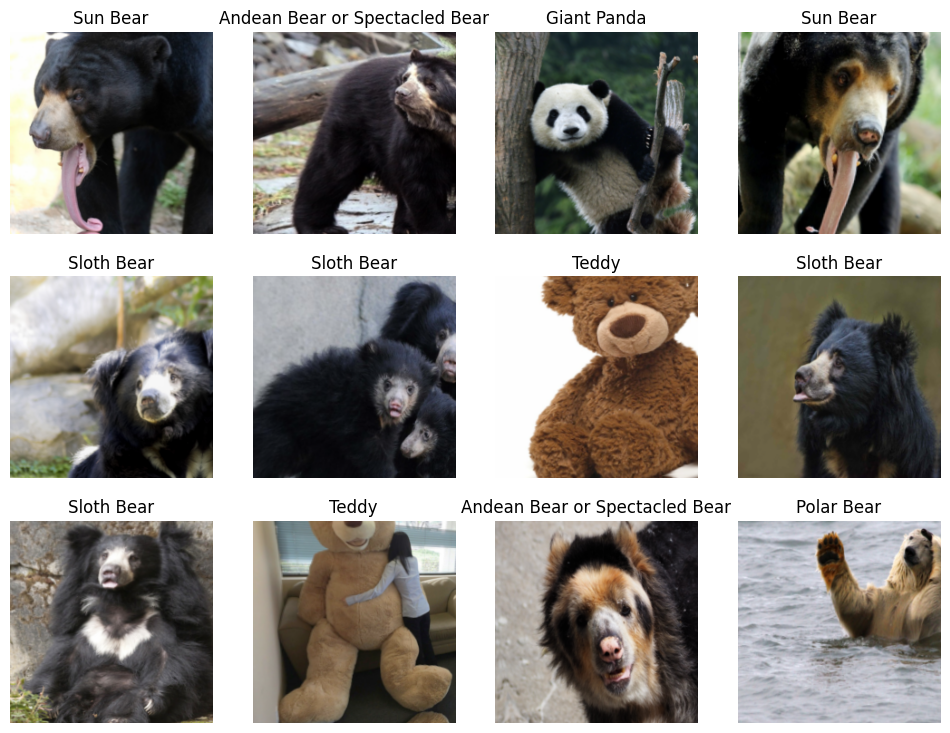

In [28]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=34),
    get_y=parent_label,
    batch_tfms=aug_transforms(),
    item_tfms=RandomResizedCrop(224, min_scale=0.5) # usaremos RandomResizedCrop con un tamaño de imagen de 224 px, que es bastante estándar para la clasificación de imágenes
).dataloaders(f'c:/{nombre_proyecto}/img'
)

dls.show_batch(max_n=12)

In [29]:
# Entrenar el modelo
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

epoch,train_loss,valid_loss,error_rate,time
0,2.392509,0.616056,0.221429,01:17


epoch,train_loss,valid_loss,error_rate,time
0,0.765796,0.334658,0.114286,01:36
1,0.597985,0.257080,0.100000,01:39
2,0.478422,0.236569,0.085714,01:32


C:\Users\ar13118\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\PIL\Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


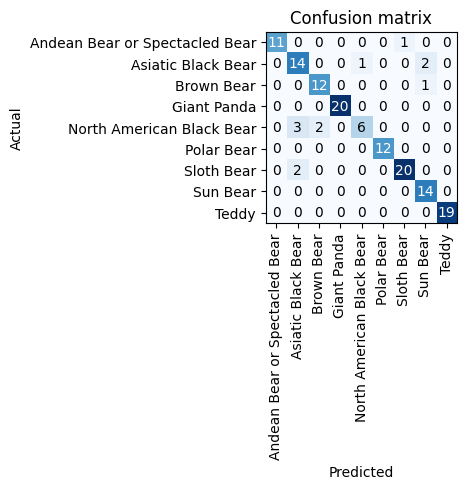

In [31]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

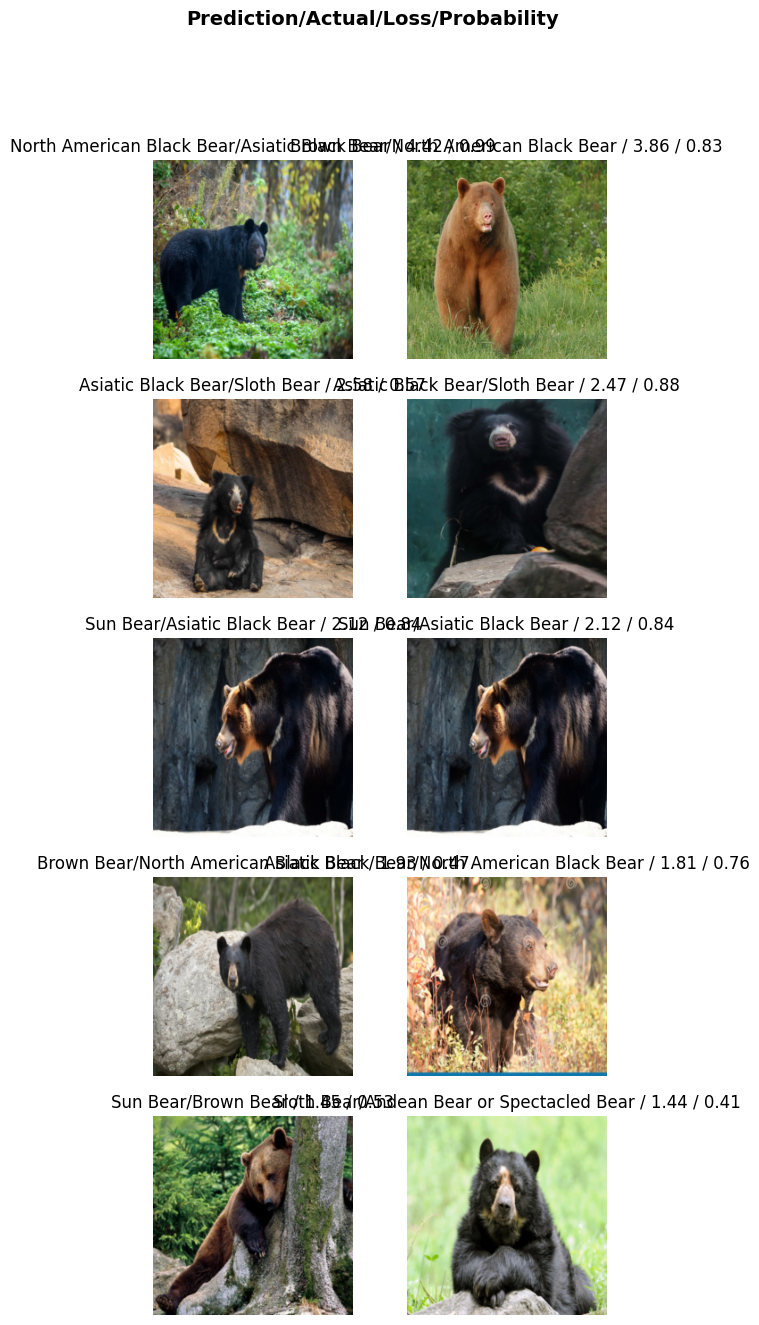

In [32]:
interp.plot_top_losses(10, nrows=5)


In [44]:
# Define the directory path
model_directory = f'c:/{nombre_proyecto}/model/'

# Create the directory if it doesn't exist
os.makedirs(model_directory, exist_ok=True)

# Export the trained model
learn.export(f'{model_directory}/{nombre_proyecto}_model.pkl')

In [49]:
learn_inf = load_learner(f'{model_directory}/{nombre_proyecto}_model.pkl')

In [57]:
learn_inf.predict('c:/osos/test/1.jfif')

('Polar Bear',
 tensor(5),
 tensor([2.1546e-04, 1.2044e-03, 4.4449e-04, 6.2097e-03, 3.7190e-03, 9.2750e-01,
         2.0456e-03, 4.1692e-03, 5.4492e-02]))

In [59]:
learn_inf.dls.vocab


['Andean Bear or Spectacled Bear', 'Asiatic Black Bear', 'Brown Bear', 'Giant Panda', 'North American Black Bear', 'Polar Bear', 'Sloth Bear', 'Sun Bear', 'Teddy']

In [1]:
import ipywidgets as widgets
from IPython.display import display

# Cargar el modelo exportado
learn = load_learner(f'{model_directory}/{nombre_proyecto}_model.pkl')

# Definir la función para manejar la carga de archivos y realizar predicciones
def on_upload_change(change):
    img = PILImage.create(upload_btn.data[-1])
    display(img)
    
    # Realizar predicciones
    prediction, index, probabilities = learn.predict(img)
    print("Categoría:", prediction)
    print("Predicción:", round(probabilities[index].item(), 4))

# Crear el botón de carga de archivos
upload_btn = widgets.FileUpload()
upload_btn.observe(on_upload_change, names='_counter')

display(upload_btn)


NameError: name 'load_learner' is not defined